In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os

# Import TDA pipeline requirements
import gudhi as gd
import json

from scipy import ndimage, interpolate

In [2]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [10]:
maximgsize = 1250
mintransnum = 5
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
ksrc = '../kde/'
csrc = '../data/'
dst = '../gd_trans/'

sample = 'D2'

ksrc += sample + os.sep
dst = dst + sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = sorted([foo.split('/')[-2] for foo in glob(ksrc + '*/')])
print(len(transcriptomes), 'transcriptomes')

97 transcriptomes


In [4]:
wallshape = (np.max(metacell['x1']), np.max(metacell['x1']))
wallshape

(17152, 17152)

In [41]:
tidx = 2
sdst = dst + transcriptomes[tidx] + os.sep
if not os.path.isdir(sdst):
    os.mkdir(sdst)

kdefiles = glob(ksrc + transcriptomes[tidx] + os.sep + '*.npy')
ratios = transcell.iloc[tidx, :-1].values.astype(float) / metatrans.loc[tidx, 'cyto_number']
#transnum = transcell.iloc[tidx, :-1].values.astype(float)
#ratios = transnum[transnum > mintransnum]/np.sum(transnum[transnum > mintransnum])

metakde = np.zeros((len(kdefiles), 4), dtype=int)
rawkdemax = np.zeros(len(metakde))
for i in range(len(kdefiles)):
    foo = (os.path.splitext(os.path.split(kdefiles[i])[1])[0]).split('_')
    for j in range(metakde.shape[1]):
        metakde[i,j] = int(foo[j][1:])
    rawkdemax[i] = float(foo[-1][1:])
metakde = pd.DataFrame(metakde, columns=['ndimage_cellID', 'pad', 'stepsize', 'bandwidth'])
metakde['rawkdemax'] = rawkdemax
metakde['transnum'] = transcell.iloc[tidx, metakde['ndimage_cellID'].values].values.astype(int)
metakde['ratio_all'] = ratios[metakde['ndimage_cellID'].values]
metakde['ratio_select'] = metakde['transnum']/np.sum(metakde['transnum'])
metakde['kdemax_all'] = metakde['rawkdemax']*metakde['ratio_all']
metakde['kdemax_select'] = metakde['rawkdemax']*metakde['ratio_select']
metakde = metakde[metakde['ndimage_cellID'] != 0]

print(metakde.shape)
#metakde.head(10)
metakde.sort_values(by='kdemax_all', ascending=False).head(10)

(1543, 10)


,ndimage_cellID,pad,stepsize,bandwidth,rawkdemax,transnum,ratio_all,ratio_select,kdemax_all,kdemax_select
1217,2151,6,5,15,0.000015,3982,0.002218,0.002221,3.240756e-08,3.244671e-08
1234,1618,6,5,15,0.000023,2471,0.001377,0.001378,3.217380e-08,3.221267e-08
1209,2307,6,5,15,0.000032,1811,0.001009,0.001010,3.204971e-08,3.208843e-08
1141,1880,6,5,15,0.000030,1877,0.001046,0.001047,3.184065e-08,3.187912e-08
269,809,6,5,15,0.000026,2135,0.001189,0.001191,3.067752e-08,3.071459e-08
1021,750,6,5,15,0.000014,3797,0.002115,0.002118,3.065380e-08,3.069083e-08
742,1154,6,5,15,0.000016,3468,0.001932,0.001934,3.005599e-08,3.009230e-08
469,1424,6,5,15,0.000015,3568,0.001988,0.001990,2.955405e-08,2.958976e-08
1073,722,6,5,15,0.000077,679,0.000378,0.000379,2.913023e-08,2.916542e-08
30,1644,6,5,15,0.000031,1676,0.000934,0.000935,2.911138e-08,2.914655e-08


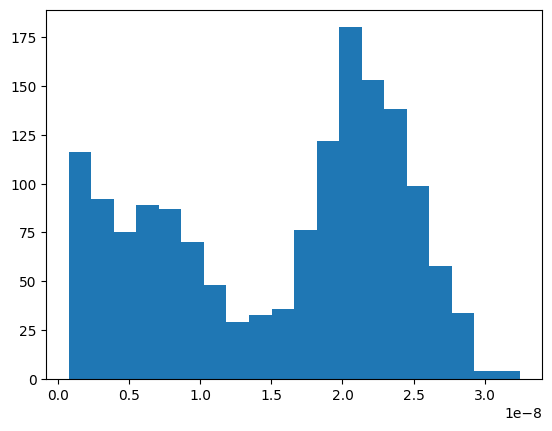

In [44]:
plt.hist(metakde['kdemax_select'], bins=20);

In [49]:
selection = 'all'
vmax = np.max(metakde['kdemax_' + selection])
bins = np.linspace(0, vmax, 256)

idx = 30

jsname = '_'.join(np.asarray(os.path.splitext(os.path.split(kdefiles[idx])[1])[0].split('_'))[[0,3]])
cidx = metakde.loc[idx,'ndimage_cellID']
kde = np.load(kdefiles[idx], allow_pickle=True)*metakde.loc[idx, 'ratio_' + selection]

In [50]:
PP = metakde.loc[idx, 'pad']
stepsize = metakde.loc[idx, 'stepsize']
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wallshape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wallshape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cy = ss[0].stop - ss[0].start
cx = ss[1].stop - ss[1].start
xaxis = np.arange(0, cx, stepsize); yaxis = np.arange(0, cy, stepsize)
xaxis += ss[1].start; yaxis += ss[0].start

In [60]:
cp = cartesian_product(np.arange(yaxis[0],yaxis[-1]), np.arange(xaxis[0],xaxis[-1]))
interp = interpolate.RegularGridInterpolator((yaxis, xaxis), kde, method='linear', bounds_error=True, fill_value=None)
img = interp(cp)
img = np.digitize(img, bins, right=True).astype(np.uint8).reshape(yaxis[-1]-yaxis[0],xaxis[-1]-xaxis[0])
img = np.pad(img, 5)

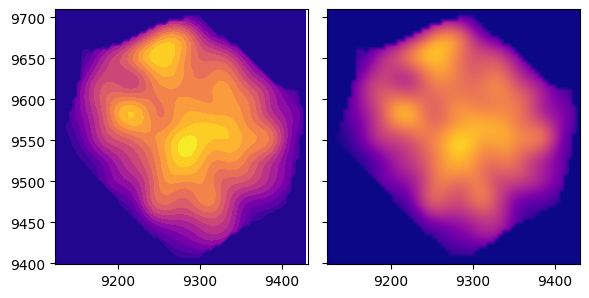

In [61]:
fs = 15
fig, ax = plt.subplots(1,2,figsize=(6,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].contourf(xaxis, yaxis, kde, 16, cmap='plasma')
ax[1].imshow(img, cmap='plasma', origin='lower', extent=extent, vmin=0, vmax=255)

for i in range(len(ax)):
    ax[i].set_aspect('equal')
    
fig.tight_layout();

# Match cells

In [62]:
if max(img.shape) > maximgsize:
    zoom = maximgsize/max(img.shape)
    print(kdefiles[idx], '\nResized', img.shape, 'by a factor of ', zoom)
    img = ndimage.zoom(img, zoom = zoom, order=1, mode='reflect')
    print('Now', img.shape, '\n----')

In [63]:
cc = gd.CubicalComplex(top_dimensional_cells = img)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1)
filename = sdst + transcriptomes[tidx] + '_' + jsname + '_sublevel.json'
with open(filename, 'w') as f:
    json.dump(pers,f)
pers

[(1, (0.0, 230.0)),
 (1, (172.0, 220.0)),
 (1, (172.0, 206.0)),
 (1, (178.0, 180.0)),
 (0, (0.0, inf)),
 (0, (112.0, 119.0))]

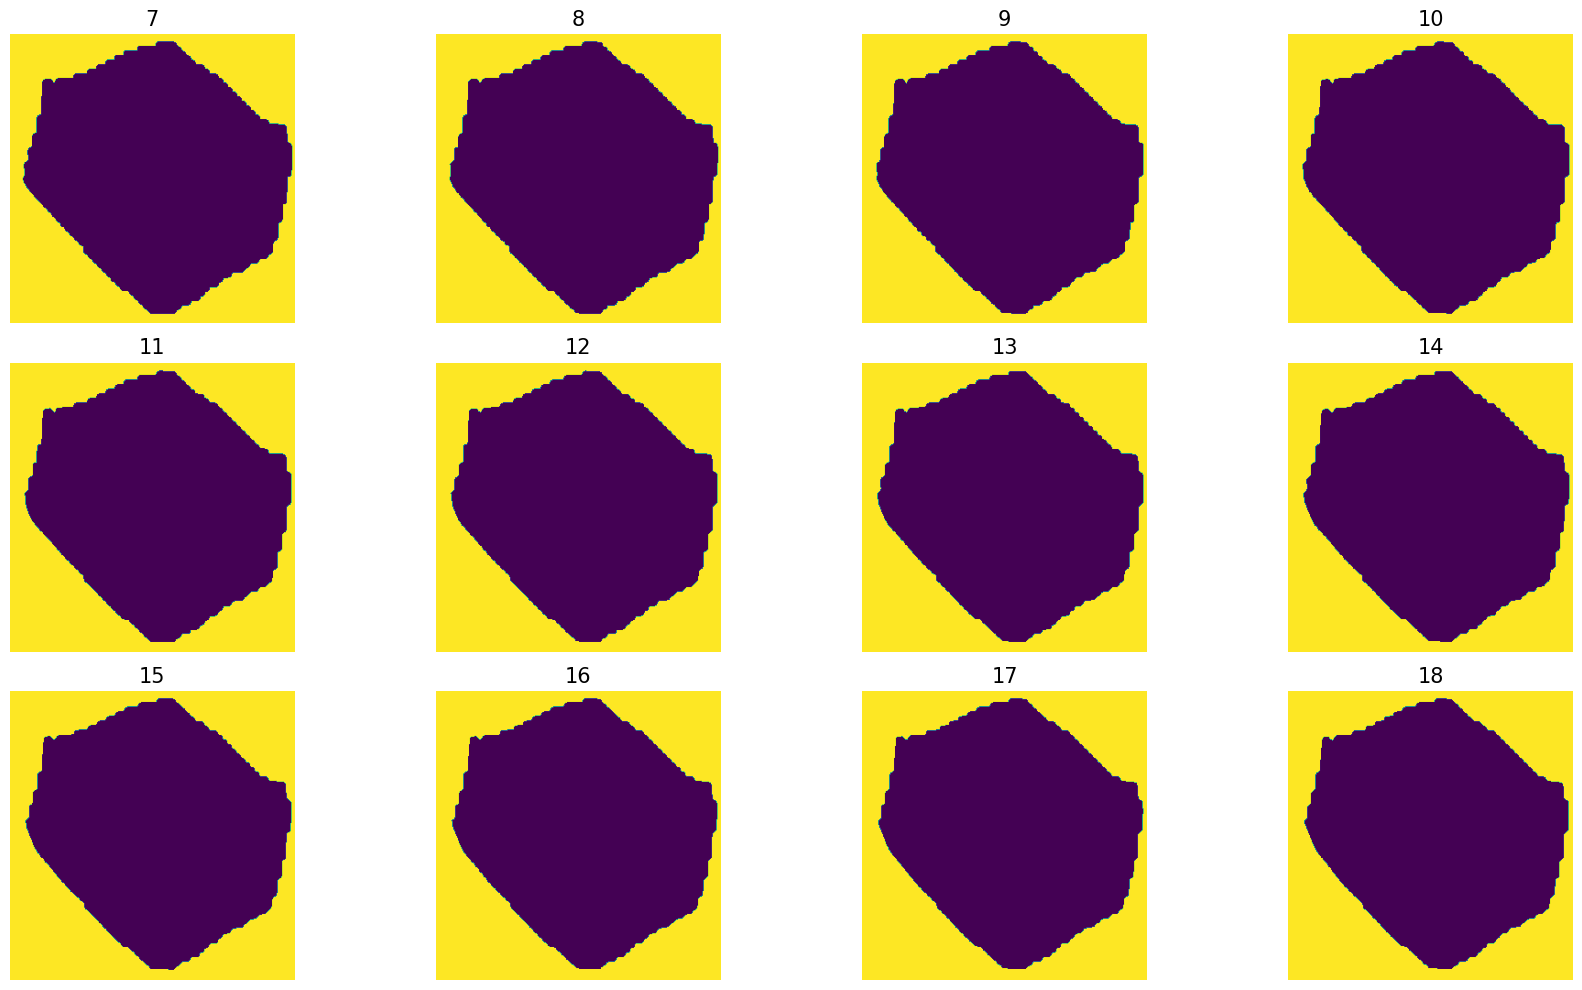

In [64]:
fig, ax = plt.subplots(3,4, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = 7

for i in range(len(ax)):
    ax[i].imshow(img <= k + i, vmin=0, vmax=1, origin='lower');
    ax[i].set_title(k + i, fontsize=15)
    ax[i].axis('off');

fig.tight_layout();

In [30]:
maxv = img.max()
cc = gd.CubicalComplex(top_dimensional_cells = maxv-img)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1)
filename = sdst + transcriptomes[tidx] + '_' + jsname + '_superlevel.json'
with open(filename, 'w') as f:
    json.dump(pers,f)
pers

[(0, (0.0, inf)), (0, (227.0, 254.0))]

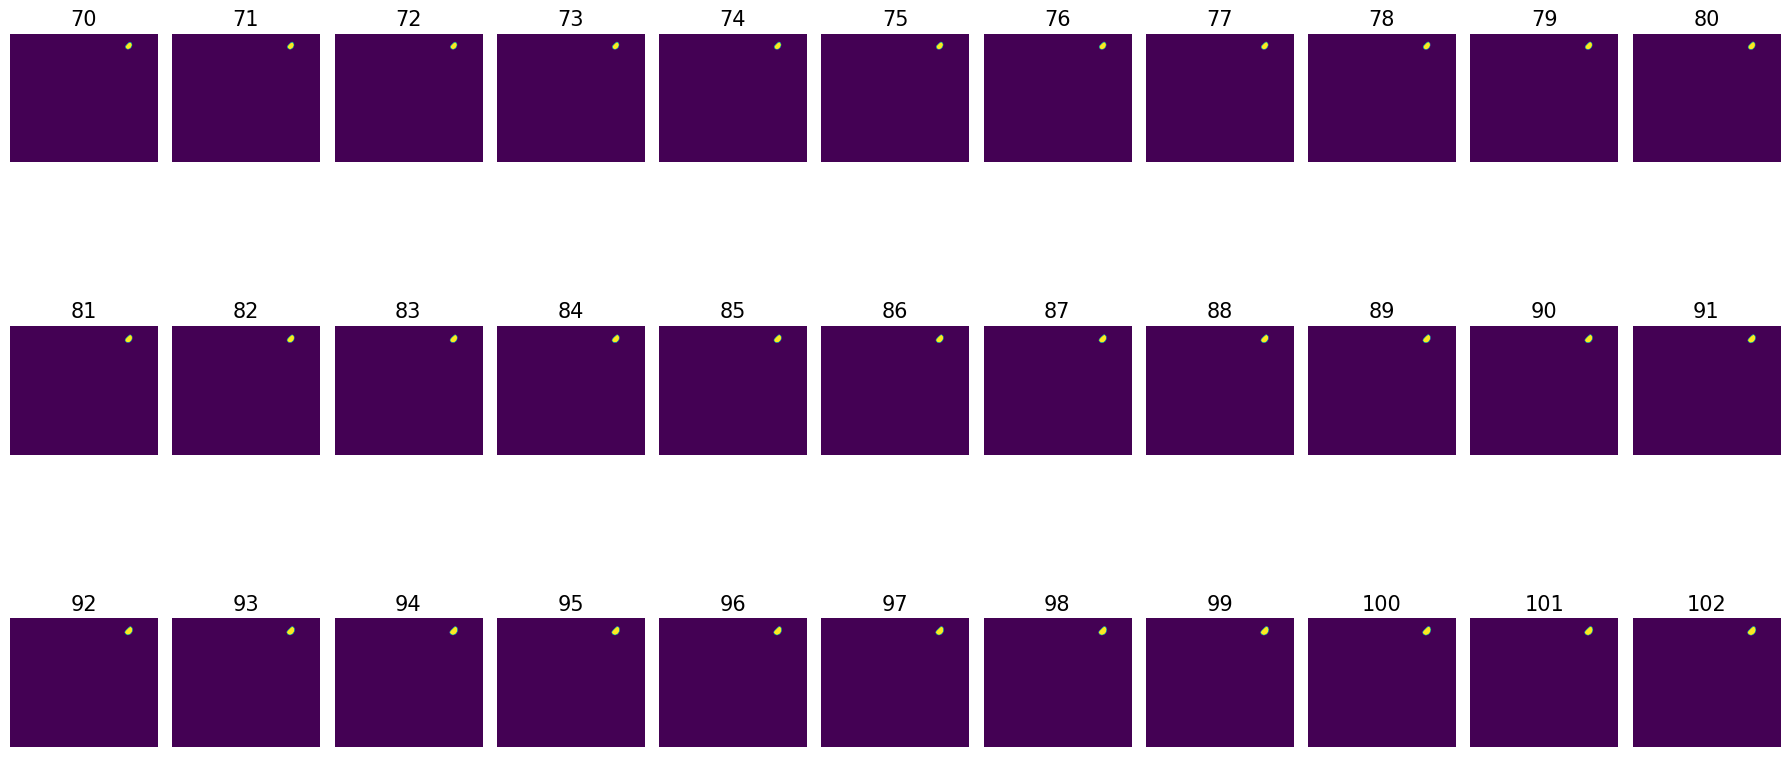

In [17]:
fig, ax = plt.subplots(3,11, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = 70
bar = maxv - img 
for i in range(len(ax)):
    #j = len(ax) - 1 - i
    j = i
    ax[j].imshow(bar <= k + i, vmin=0, vmax=1, origin='lower');
    ax[j].set_title(k + i, fontsize=15)
    ax[j].axis('off');

fig.tight_layout();